In [ ]:
# import numpy as np
# import pandas as pd


#df = pd.read_csv('../data/processed/processed_data.csv')

In [ ]:
# df.shape


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# import numpy as np
# import pandas as pd

# X = df.drop('Label', axis=1)  #
# y = df['Label']

# # Encode labels

encode_labels = LabelEncoder()
y_encoded = encode_labels.fit_transform(y)


# X_train,X_test,y_train,y_test = train_test_split(
#     X,
#     y_encoded,
#     test_size = 0.15,  # 15 % test
#     random_state = 42,
#     stratify=y_encoded
# )


# X_train.to_csv('split_data/X_train.csv',index=False)
# pd.DataFrame(y_train,columns=['Label']).to_csv('split_data/y_train.csv')
# X_test.to_csv('split_data/X_test.csv',index=False)
# pd.DataFrame(y_test,columns=['Label']).to_csv('split_data/y_test.csv')


In [ ]:
# savel label encoder 
import joblib
joblib.dump(encode_labels,'split_data/label_encoder/label_encoder.pkl')

In [ ]:
# load the data
import numpy as np
import pandas as pd

X_train = pd.read_csv('split_data/X_train.csv')
y_train = pd.read_csv('split_data/y_train.csv')
X_test = pd.read_csv('split_data/X_test.csv')
y_test = pd.read_csv('split_data/y_test')

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib


encode_labels = joblib.load('split_data/label_encoder/label_encoder.pkl')

# Normalize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


num_classes = len(encode_labels.classes_)
y_train_onehot = np.eye(num_classes)[y_train['Label']]
y_test_onehot = np.eye(num_classes)[y_test['Label']]

In [ ]:
X_train.columns

In [ ]:
X_train.shape

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class HybridLSTMCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HybridLSTMCNN, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=1)  # kernel_size=1
        self.dropout1 = nn.Dropout(0.5)
        
        # LSTM Layers
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=100, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        
        # Output Layer
        self.fc = nn.Linear(50, num_classes)
    
    def forward(self, x):
        
        
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [15]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_reshaped)
y_train_tensor = torch.LongTensor(y_train['Label'].values)  # Using class indices, not one-hot

X_test_tensor = torch.FloatTensor(X_test_reshaped)
y_test_tensor = torch.LongTensor(y_test['Label'].values)

# Create DataLoaders
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 1024  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridLSTMCNN(input_dim=X_train_scaled.shape[1], num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [ ]:
num_epochs = 15  

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
   
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    
    scheduler.step(val_loss)
    
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(test_loader):.4f}')
    print(f'Val Accuracy: {100 * correct / total:.2f}%')
    print('-' * 50)

Epoch 1/15:
Train Loss: 0.1628 | Val Loss: 0.0361
Val Accuracy: 99.15%
--------------------------------------------------
Epoch 2/15:
Train Loss: 0.0358 | Val Loss: 0.0397
Val Accuracy: 98.73%
--------------------------------------------------
Epoch 3/15:
Train Loss: 0.0293 | Val Loss: 0.0426
Val Accuracy: 98.70%
--------------------------------------------------
Epoch 4/15:
Train Loss: 0.0261 | Val Loss: 0.0607
Val Accuracy: 98.60%
--------------------------------------------------
Epoch 5/15:
Train Loss: 0.0236 | Val Loss: 0.0777
Val Accuracy: 98.53%
--------------------------------------------------
Epoch 6/15:
Train Loss: 0.0203 | Val Loss: 0.0610
Val Accuracy: 98.71%
--------------------------------------------------
Epoch 7/15:
Train Loss: 0.0196 | Val Loss: 0.0635
Val Accuracy: 98.67%
--------------------------------------------------
Epoch 8/15:
Train Loss: 0.0194 | Val Loss: 0.0714
Val Accuracy: 98.59%
--------------------------------------------------
Epoch 9/15:
Train Loss: 

Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       0.99      1.00      0.99    314259
                       Bot       1.00      0.35      0.51       292
                      DDoS       1.00      0.99      1.00     19202
             DoS GoldenEye       0.92      0.24      0.38      1543
                  DoS Hulk       1.00      0.89      0.94     25927
          DoS Slowhttptest       0.90      0.88      0.89       784
             DoS slowloris       0.99      0.86      0.92       808
               FTP-Patator       1.00      0.98      0.99       890
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         5
                  PortScan       0.99      1.00      0.99     13604
               SSH-Patator       1.00      0.90      0.95       483
  Web Attack � Brute Force       0.65      0.80      0.72       220
Web Attack � Sql Injecti

/home/ahmed/deep-anomaly-ips/ips_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmed/deep-anomaly-ips/ips_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ahmed/deep-anomaly-ips/ips_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

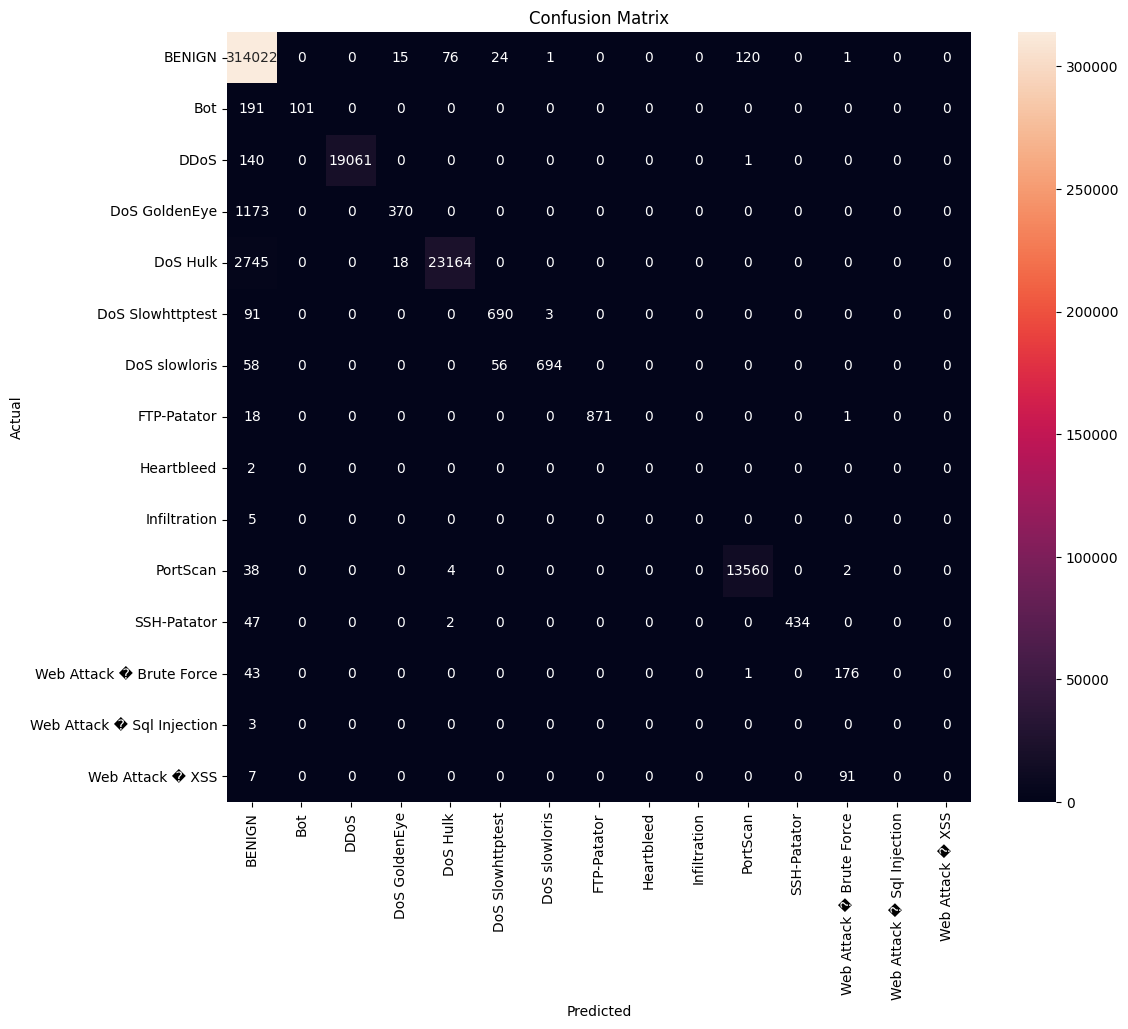

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encode_labels.classes_))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=encode_labels.classes_, 
            yticklabels=encode_labels.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()